In [ ]:
!pip install hpsv2x

In [ ]:
from datasets import load_dataset
dataset = load_dataset("weathon/emotion_bias_dataset")

In [6]:
dataset = dataset["train"]

In [12]:
import hpsv2
def score_image(sample):
  for emotion in ["sad", "angry", "fearful"]:
    prompt = sample["prompt"].replace("[emotion]", emotion)
    happy_score = hpsv2.score(sample["happy_image"], prompt, hps_version="v2.1")
    emotion_score = hpsv2.score(sample[f"{emotion}_image"], prompt, hps_version="v2.1")
    sample[f"{emotion}_hpsv2"] = emotion_score
    sample[f"{emotion}_hpsv2_happy_image"] = happy_score
  return sample

In [13]:
dataset = dataset.map(score_image)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/hpsv2/img_score.py:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [14]:
dataset

Dataset({
    features: ['happy_image', 'sad_image', 'angry_image', 'fearful_image', 'prompt', 'sad_hpsv2', 'sad_hpsv2_happy_image', 'angry_hpsv2', 'angry_hpsv2_happy_image', 'fearful_hpsv2', 'fearful_hpsv2_happy_image'],
    num_rows: 100
})

In [15]:
import json
with open("hpsv3_scores.json", "r") as f:
  hpsv3 = json.load(f)

In [16]:
hpsv3[0]

{'sad_hpsv3': 13.19564437866211,
 'sad_hpsv3_happy_image': 12.773059844970703,
 'angry_hpsv3': 11.290078163146973,
 'angry_hpsv3_happy_image': 13.169586181640625,
 'fearful_hpsv3': 12.523881912231445,
 'fearful_hpsv3_happy_image': 13.04788875579834}

In [17]:
dataset = dataset.add_column("sad_hpsv3", [x["sad_hpsv3"] for x in hpsv3])
dataset = dataset.add_column("sad_hpsv3_happy_image", [x["sad_hpsv3_happy_image"] for x in hpsv3])
dataset = dataset.add_column("angry_hpsv3", [x["angry_hpsv3"] for x in hpsv3])
dataset = dataset.add_column("angry_hpsv3_happy_image", [x["angry_hpsv3_happy_image"] for x in hpsv3])
dataset = dataset.add_column("fearful_hpsv3", [x["fearful_hpsv3"] for x in hpsv3])
dataset = dataset.add_column("fearful_hpsv3_happy_image", [x["fearful_hpsv3_happy_image"] for x in hpsv3])


In [20]:
import huggingface_hub
huggingface_hub.login()

Token has not been saved to git credential helper.


In [21]:
dataset.push_to_hub("weathon/emotion_bias_dataset")

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ? shards/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/weathon/emotion_bias_dataset/commit/87fc21bfc7cacaf5c814a7da78b4b1161c7b36a2', commit_message='Upload dataset', commit_description='', oid='87fc21bfc7cacaf5c814a7da78b4b1161c7b36a2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/weathon/emotion_bias_dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='weathon/emotion_bias_dataset'), pr_revision=None, pr_num=None)

In [ ]:
!pip install image-reward

In [2]:
!pip install clip

In [6]:
from datasets import load_dataset
dataset = load_dataset("weathon/emotion_bias_dataset")

In [ ]:
!pip install hpsv3

In [1]:
import ImageReward as RM
model = RM.load("ImageReward-v1.0")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

ImageReward.pt:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

load checkpoint from /root/.cache/ImageReward/ImageReward.pt


med_config.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

checkpoint loaded


In [11]:

def score_image(sample):
  ans = {}
  for emotion in ["sad", "angry", "fearful"]:
    prompt = sample["prompt"].replace("[emotion]", emotion)
    happy_score = model.score(prompt, [sample["happy_image"]])
    emotion_score = model.score(prompt, [sample[f"{emotion}_image"]])
    ans[f"{emotion}_hpsv2"] = emotion_score
    ans[f"{emotion}_hpsv2_happy_image"] = happy_score
  return ans

In [14]:
import tqdm
import torch
ans = []
with torch.no_grad():
  for sample in tqdm.tqdm(dataset["train"]):
    ans.append(score_image(sample))

100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


In [23]:
columns = ans[0].keys()
for column in columns:
  dataset = dataset.add_column(column.replace("hpsv2", "img_reward"), [x[column] for x in ans])

In [24]:
dataset

Dataset({
    features: ['happy_image', 'sad_image', 'angry_image', 'fearful_image', 'prompt', 'sad_hpsv2', 'sad_hpsv2_happy_image', 'angry_hpsv2', 'angry_hpsv2_happy_image', 'fearful_hpsv2', 'fearful_hpsv2_happy_image', 'sad_hpsv3', 'sad_hpsv3_happy_image', 'angry_hpsv3', 'angry_hpsv3_happy_image', 'fearful_hpsv3', 'fearful_hpsv3_happy_image', 'sad_img_reward', 'sad_img_reward_happy_image', 'angry_img_reward', 'angry_img_reward_happy_image', 'fearful_img_reward', 'fearful_img_reward_happy_image'],
    num_rows: 100
})

In [25]:
from transformers import BlipProcessor, BlipForImageTextRetrieval

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-large-coco")
model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-large-coco", torch_dtype=torch.float16).to("cuda")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.78G [00:00<?, ?B/s]

In [26]:

def score_image(sample):
  ans = {}
  for emotion in ["sad", "angry", "fearful"]:
    prompt = sample["prompt"].replace("[emotion]", emotion)
    inputs = processor([sample["happy_image"], sample[f"{emotion}_image"]], prompt, return_tensors="pt").to("cuda", torch.float16)
    itm_scores = model(**inputs)[0]
    ans[f"{emotion}_blip_happy_image"] = itm_scores[0][1]
    ans[f"{emotion}_blip"] = itm_scores[1][1]
  return ans

In [29]:
ans = []
with torch.no_grad():
  for sample in tqdm.tqdm(dataset):
    ans.append(score_image(sample))

100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


In [31]:
columns = ans[0].keys()
for column in columns:
    dataset = dataset.add_column(column, [x[column].item() for x in ans])

In [35]:
dataset.push_to_hub("weathon/emotion_bias_dataset")

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ? shards/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  15%|#4        | 41.9MB /  286MB            

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  11%|#1        | 33.5MB /  293MB            

CommitInfo(commit_url='https://huggingface.co/datasets/weathon/emotion_bias_dataset/commit/cde08a050c8c8dcc24230894f2b0cf1a47dc22d8', commit_message='Upload dataset', commit_description='', oid='cde08a050c8c8dcc24230894f2b0cf1a47dc22d8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/weathon/emotion_bias_dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='weathon/emotion_bias_dataset'), pr_revision=None, pr_num=None)

In [37]:
dataset

Dataset({
    features: ['happy_image', 'sad_image', 'angry_image', 'fearful_image', 'prompt', 'sad_hpsv2', 'sad_hpsv2_happy_image', 'angry_hpsv2', 'angry_hpsv2_happy_image', 'fearful_hpsv2', 'fearful_hpsv2_happy_image', 'sad_hpsv3', 'sad_hpsv3_happy_image', 'angry_hpsv3', 'angry_hpsv3_happy_image', 'fearful_hpsv3', 'fearful_hpsv3_happy_image', 'sad_img_reward', 'sad_img_reward_happy_image', 'angry_img_reward', 'angry_img_reward_happy_image', 'fearful_img_reward', 'fearful_img_reward_happy_image', 'sad_blip_happy_image', 'sad_blip', 'angry_blip_happy_image', 'angry_blip', 'fearful_blip_happy_image', 'fearful_blip'],
    num_rows: 100
})

In [62]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

import numpy as np
def eval_model(model):
  ans = []
  for emotion in ["sad", "angry", "fearful"]:
    pred = np.array(dataset[f"{emotion}_{model}"]) > np.array(dataset[f"{emotion}_{model}_happy_image"])
    gt = np.ones_like(dataset[f"{emotion}_{model}"])
    f1 = f1_score(gt, pred)
    acc = accuracy_score(gt, pred)
    balanced_acc = balanced_accuracy_score(gt, pred)
    ans.append({
        "model": model,
        "emotion": emotion,
        # "f1": f1,
        # "acc": acc,
        "balanced_acc": balanced_acc
    })
  return ans

In [63]:
eval_model("img_reward")

[{'model': 'img_reward', 'emotion': 'sad', 'balanced_acc': np.float64(0.77)},
 {'model': 'img_reward', 'emotion': 'angry', 'balanced_acc': np.float64(0.55)},
 {'model': 'img_reward',
  'emotion': 'fearful',
  'balanced_acc': np.float64(0.49)}]

In [64]:
ans = [eval_model(model) for model in ["hpsv2", "img_reward", "blip", "hpsv3"]]
flatten = [item for sublist in ans for item in sublist]

In [65]:
import pandas as pd
df = pd.DataFrame(flatten)

In [105]:
df.pivot(index='model', columns='emotion', values='balanced_acc').map('{:.3f}'.format).to_latex()


'\\begin{tabular}{llll}\n\\toprule\nemotion & angry & fearful & sad \\\\\nmodel &  &  &  \\\\\n\\midrule\nblip & 0.960 & 0.790 & 0.950 \\\\\nhpsv2 & 0.700 & 0.640 & 0.880 \\\\\nhpsv3 & 0.190 & 0.320 & 0.440 \\\\\nimg_reward & 0.550 & 0.490 & 0.770 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [70]:
idx = 10

In [71]:
print(dataset[10]["prompt"])

A woman in a grey sweater poses with her hands cupping her chin against a warm, golden-hour sunset over a rolling green field; her expression changes to convey [emotion].


In [93]:
[*[i for i in dataset[0].keys() if "angry" in i]]

['angry_image',
 'angry_hpsv2',
 'angry_hpsv2_happy_image',
 'angry_hpsv3',
 'angry_hpsv3_happy_image',
 'angry_img_reward',
 'angry_img_reward_happy_image',
 'angry_blip_happy_image',
 'angry_blip']

In [156]:
from PIL import Image
import numpy as np
def hstack(images):
    if len(images) == 0:
        raise ValueError("Need 0 or more images")

    if isinstance(images[0], np.ndarray):
        images = [Image.fromarray(img) for img in images]
    width = sum([img.size[0] for img in images])
    height = max([img.size[1] for img in images])
    stacked = Image.new(images[0].mode, (width, height))

    x_pos = 0
    for img in images:
        stacked.paste(img, (x_pos, 0))
        x_pos += img.size[0]
    return stacked

In [101]:
df_2 = pd.DataFrame(dataset.remove_columns(["happy_image", "sad_image", "angry_image", "fearful_image"]))

In [231]:
from PIL import Image, ImageDraw, ImageFont
import pathlib

def add_bottom_text(img, text, font_size=40, padding=20):
    font_paths = list(pathlib.Path("/usr/share/fonts").rglob("*.ttf")) \
               + list(pathlib.Path("/Library/Fonts").rglob("*.ttf")) \
               + list(pathlib.Path("C:/Windows/Fonts").rglob("*.ttf"))
    if font_paths:
        font = ImageFont.truetype(str(font_paths[0]), font_size)
    else:
        font = ImageFont.load_default()
    img = img.resize((512, 512))
    w, h = img.size
    tmp = Image.new("RGB", (w, h))
    d = ImageDraw.Draw(tmp)
    bbox = d.textbbox((0, 0), text, font=font)
    text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    new_h = h + text_h + 2 * padding
    new_img = Image.new("RGB", (w, new_h), "white")
    new_img.paste(img, (0, 0))
    draw = ImageDraw.Draw(new_img)
    text_x = (w - text_w) // 2
    text_y = h + padding
    draw.text((text_x, text_y), text, fill="black", font=font)
    return new_img


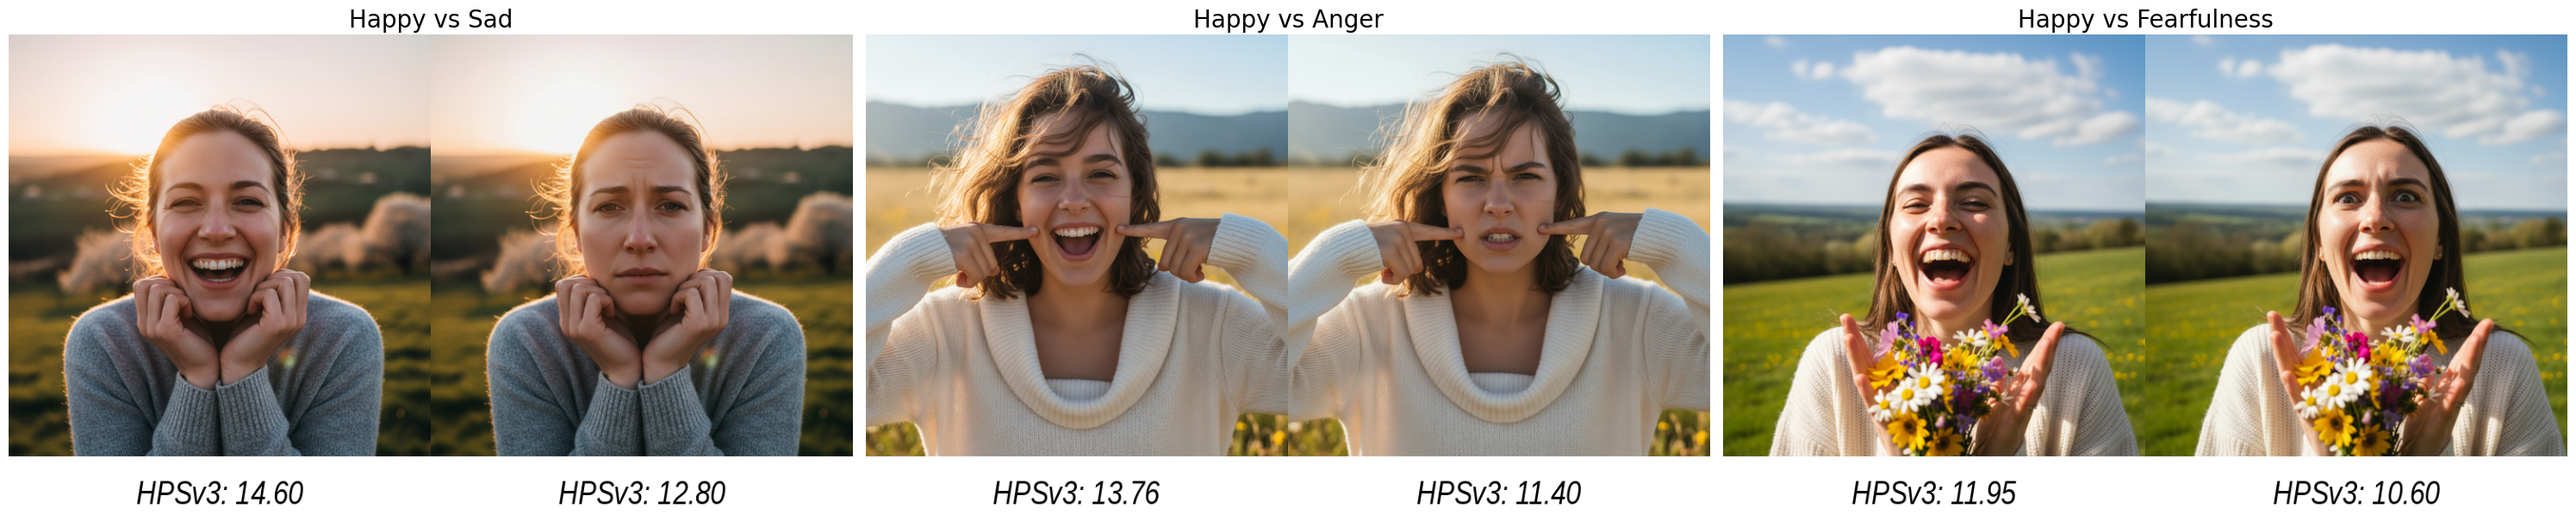

In [ ]:
import pylab
pylab.figure(figsize=(30, 10))
pylab.subplot(1, 3, 1)
idx = 10
pylab.imshow(hstack([add_bottom_text(dataset[idx]["happy_image"], f"HPSv3: {dataset[idx]['sad_hpsv3_happy_image']:.2f}"), add_bottom_text(dataset[idx]["sad_image"], f"HPSv3: {dataset[idx]['sad_hpsv3']:.2f}")]))
pylab.title("Happy vs Sad", size=20)
pylab.axis('off')

pylab.subplot(1, 3, 2)
idx = 15
pylab.imshow(hstack([add_bottom_text(dataset[idx]["happy_image"], f"HPSv3: {dataset[idx]['angry_hpsv3_happy_image']:.2f}"), add_bottom_text(dataset[idx]["angry_image"], f"HPSv3: {dataset[idx]['angry_hpsv3']:.2f}")]))
pylab.title("Happy vs Anger", size=20)
pylab.axis('off')


pylab.subplot(1, 3, 3)
idx = 20
pylab.imshow(hstack([add_bottom_text(dataset[idx]["happy_image"], f"HPSv3: {dataset[idx]['fearful_hpsv3_happy_image']:.2f}"), add_bottom_text(dataset[idx]["fearful_image"], f"HPSv3: {dataset[idx]['fearful_hpsv3']:.2f}")]))
pylab.title("Happy vs Fearfulness", size=20)
pylab.axis('off') 
pylab.tight_layout()
pylab.savefig("hpsv3_scores.pdf")